<h1>Download Data</h1>

In [48]:
# !kaggle datasets download -p ../dataset -d faizalkarim/flood-area-segmentation 


<h1>Extract zip folder</h1>

In [49]:
# !tar -xf ../dataset/flood-area-segmentation.zip -C ../dataset/main

<h1>Import particular module</h1>

In [50]:
import os
import cv2
import shutil
import numpy as np
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
import ipywidgets as widgets



<h1>Define folder path</h1>

In [51]:
MAIN_IMAGES_PATH = '../dataset/main/Image/'
MAIN_MASKS_PATH = '../dataset/main/Mask/'

SPLIT_IMAGES_PATH = '../dataset/split/Image/'
SPLIT_MASKS_PATH = '../dataset/split/Mask/'

TRAIN_IMAGES_PATH = '../dataset/train/Image/'
TRAIN_MASKS_PATH = '../dataset/train/Mask/'

TEST_IMAGES_PATH = '../dataset/test/Image/'
TEST_MASKS_PATH = '../dataset/test/Mask/'

VAL_IMAGES_PATH = '../dataset/val/Image/'
VAL_MASKS_PATH = '../dataset/val/Mask/'

<h1>Config Parameters</h1>

In [52]:
# EfficientNet-B4	
H = 380
W = 380
BATCH_SIZE = 32
N_EPOCHS = 25
WEIGHTS_FILE_PATH = '../callbacks/flood_area_seg.h5'
CSV_FILE_PATH = '../callbacks/csv_logger.csv'

<h1>visualize image with mask</h1>

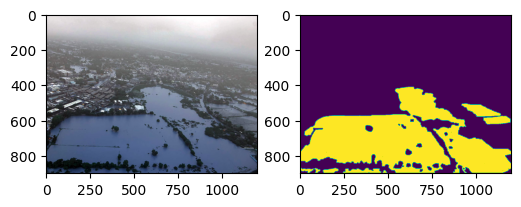

In [53]:
main_images_file = sorted(os.listdir(MAIN_IMAGES_PATH))

def showIm(index):
    main_image_file = main_images_file[index]
    main_mask_file = main_image_file[:-3] + 'png'

    main_image_file_path = os.path.join(MAIN_IMAGES_PATH,main_image_file)
    main_mask_file_path = os.path.join(MAIN_MASKS_PATH,main_mask_file)
    
    main_image_cv = cv2.imread(main_image_file_path,cv2.IMREAD_COLOR)
    main_mask_cv = cv2.imread(main_mask_file_path,cv2.IMREAD_GRAYSCALE)

    fig,axis = plt.subplots(1,2,figsize = (6,9))

    axis[0].imshow(main_image_cv)
    axis[1].imshow(main_mask_cv.astype(np.float32))

# showim_slider = widgets.IntSlider(min = 1 ,max = len(main_images_file)-1,value = 2)
# widgets.interactive(showIm,index = showim_slider)
showIm(1)



<h1>Show Unique Shape Value</h1>

In [54]:
def printUniqueShapeValue():
    shape_images = []

    main_images_file = os.listdir(MAIN_IMAGES_PATH)
    for main_image_file in main_images_file:
        main_image_file_path = os.path.join(MAIN_IMAGES_PATH,main_image_file)
        main_image_cv = cv2.imread(main_image_file_path,cv2.IMREAD_COLOR)
        shape_images.append(main_image_cv.shape)

    print(np.sort(np.unique(shape_images,axis=0),axis=0))
    


In [55]:
printUniqueShapeValue()

[[ 300  357    3]
 [ 300  374    3]
 [ 300  400    3]
 [ 311  400    3]
 [ 312  402    3]
 [ 314  450    3]
 [ 328  480    3]
 [ 332  500    3]
 [ 337  512    3]
 [ 338  553    3]
 [ 338  587    3]
 [ 341  590    3]
 [ 344  590    3]
 [ 350  595    3]
 [ 350  600    3]
 [ 351  600    3]
 [ 352  600    3]
 [ 354  600    3]
 [ 355  600    3]
 [ 360  600    3]
 [ 361  600    3]
 [ 366  600    3]
 [ 372  604    3]
 [ 373  610    3]
 [ 378  612    3]
 [ 381  612    3]
 [ 389  612    3]
 [ 390  620    3]
 [ 390  620    3]
 [ 394  620    3]
 [ 400  621    3]
 [ 400  626    3]
 [ 400  626    3]
 [ 400  626    3]
 [ 400  626    3]
 [ 402  628    3]
 [ 402  630    3]
 [ 404  630    3]
 [ 407  630    3]
 [ 408  634    3]
 [ 410  640    3]
 [ 414  640    3]
 [ 415  640    3]
 [ 417  640    3]
 [ 418  650    3]
 [ 420  650    3]
 [ 422  660    3]
 [ 422  660    3]
 [ 432  660    3]
 [ 433  660    3]
 [ 433  670    3]
 [ 434  681    3]
 [ 438  693    3]
 [ 440  700    3]
 [ 440  700    3]
 [ 440  70

In [56]:
def deleteLowDens():
    main_images_file = os.listdir(MAIN_IMAGES_PATH)
    for main_image_file in main_images_file:
        main_image_file_path = os.path.join(MAIN_IMAGES_PATH,main_image_file)
        main_image_cv = cv2.imread(main_image_file_path,cv2.IMREAD_COLOR)
        if main_image_cv.shape[0]<300:
            os.remove(main_image_file_path)

In [57]:
# deleteLowDens()

<h1>Split image into smaller sections</h1>

Main Image Shape :  (300, 500, 3)
Cropped Image Shape :  (300, 380, 3)


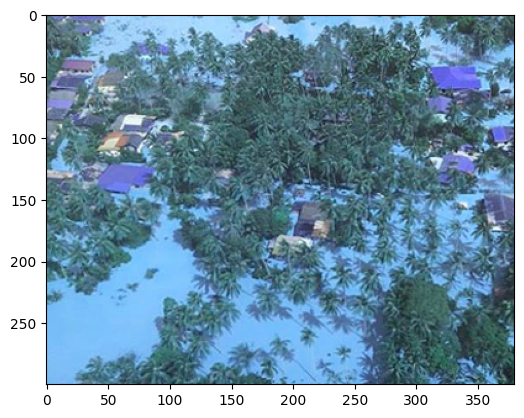

In [58]:
main_images_file = os.listdir(MAIN_IMAGES_PATH)
def showCroppedIm(index):
    main_image_file = main_images_file[index]
    main_image_file_path = os.path.join(MAIN_IMAGES_PATH,main_image_file)
    main_image_cv = cv2.imread(main_image_file_path,cv2.IMREAD_COLOR)
    
    # Set the initial size of each crop
    width = W
    height = H

    # Calculate the number of vertical and horizontal sections
    ver_sections = main_image_cv.shape[0] // height
    hor_sections = main_image_cv.shape[1] // width
    
    # If the number of sections is too large, reduce the number by increasing crop size
    if ver_sections*hor_sections > 20:
        height = H*3
        width = W*3
        ver_sections = main_image_cv.shape[0] // height
        hor_sections = main_image_cv.shape[1] // width

    # Ensure at least one section exists
    if ver_sections == 0 :ver_sections = 1
    if hor_sections == 0 :hor_sections = 1

    # Crop the main image to fit the calculated sections
    cropped_image_cv = main_image_cv[0:ver_sections*height,0:hor_sections*width]    

    fig,axis = plt.subplots(ver_sections,hor_sections)
    try:
        if len(axis.shape) == 1 : axis = axis.reshape(ver_sections,hor_sections)
        for hor_sec in range(hor_sections):
            for ver_sec in range(ver_sections):
                axis[ver_sec,hor_sec].axis('off')
                axis[ver_sec,hor_sec].imshow(cropped_image_cv[ver_sec*height:(ver_sec+1)*height,hor_sec*width:(hor_sec+1)*width])
    except:
        axis.imshow(cropped_image_cv[0:cropped_image_cv.shape[0],0:cropped_image_cv.shape[1]])
    
    

    main_image_shape = str(main_image_cv.shape[:])
    cropped_image_shape = str(cropped_image_cv.shape[:])

    print('Main Image Shape : ',main_image_shape )
    print('Cropped Image Shape : ',cropped_image_shape )
    

# slider_showCroppedIm = widgets.IntSlider(min = 0 ,max=len(main_images_file)-1 ,value = 35)
# widgets.interactive(showCroppedIm,index = slider_showCroppedIm)
showCroppedIm(0)


<h4>Move split images into split folder</h4>

In [59]:
def moveCroppedIm():
    SEC_THRESH = 20
    main_images_file = os.listdir(MAIN_IMAGES_PATH)

    for main_image_file in main_images_file:
        main_image_file_path = os.path.join(MAIN_IMAGES_PATH,main_image_file)
        main_mask_file_path = os.path.join(MAIN_MASKS_PATH,main_image_file[:-3]+'png')

        main_image_cv = cv2.imread(main_image_file_path,cv2.IMREAD_COLOR)
        main_mask_cv = cv2.imread(main_mask_file_path,cv2.IMREAD_GRAYSCALE)
        
        # Set the initial size of each crop
        width = W
        height = H

        # Calculate the number of vertical and horizontal sections
        ver_sections = main_image_cv.shape[0] // height
        hor_sections = main_image_cv.shape[1] // width
        
        # If the number of sections is too large, reduce the number by increasing crop size
        if ver_sections*hor_sections > 20:
            height = H*3
            width = W*3
            ver_sections = main_image_cv.shape[0] // height
            hor_sections = main_image_cv.shape[1] // width

        # Ensure at least one section exists
        if ver_sections == 0 :ver_sections = 1
        if hor_sections == 0 :hor_sections = 1

        # Crop the main image to fit the calculated sections
        cropped_image_cv = main_image_cv[0:ver_sections*height,0:hor_sections*width]  
        cropped_mask_cv = main_mask_cv[0:ver_sections*height,0:hor_sections*width]  

        for hor_sec in range(hor_sections):
            for ver_sec in range(ver_sections):
                split_image = cropped_image_cv[ver_sec*height:(ver_sec+1)*height,hor_sec*width:(hor_sec+1)*width]
                split_mask = cropped_mask_cv[ver_sec*height:(ver_sec+1)*height,hor_sec*width:(hor_sec+1)*width]
                
                min_dim = np.argmin(split_image.shape[:2])
                min_size = split_image.shape[min_dim]

                if (min_dim == 0 and min_size < H) or (min_dim == 1 and min_size < W) :
                    
                    if  min_dim == 0 :
                        diff_ratio = min_size/H
                    else:
                        diff_ratio = min_size/W

                    final_height = split_image.shape[0]/diff_ratio
                    final_width = split_image.shape[1]/diff_ratio

                    split_image = cv2.resize(split_image,(int(final_height),int(final_width)))
                    split_mask = cv2.resize(split_mask,(int(final_height),int(final_width)))

                    split_image = split_image[:H,:W]
                    split_mask = split_mask[:H,:W]

                else:
                    split_image = cv2.resize(split_image,(H,W))
                    split_mask = cv2.resize(split_mask,(H,W))
                    
                
                split_image_file_path = os.path.join(SPLIT_IMAGES_PATH,main_image_file[:-4]+'-'+str(hor_sec)+'-'+str(ver_sec)+'.jpg')
                split_mask_file_path = os.path.join(SPLIT_MASKS_PATH,main_image_file[:-4]+'-'+str(hor_sec)+'-'+str(ver_sec)+'.png')
            
                cv2.imwrite(split_image_file_path,split_image)
                cv2.imwrite(split_mask_file_path,split_mask)



                

In [60]:
# moveCroppedIm()

<h4>Check split images</h4>

(380, 380, 3)
(380, 380)


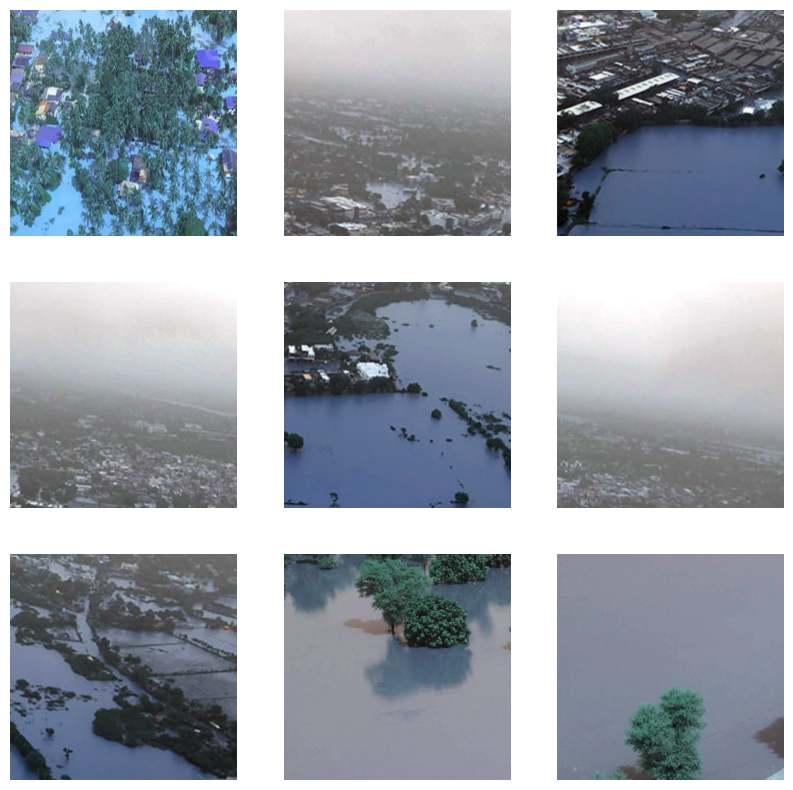

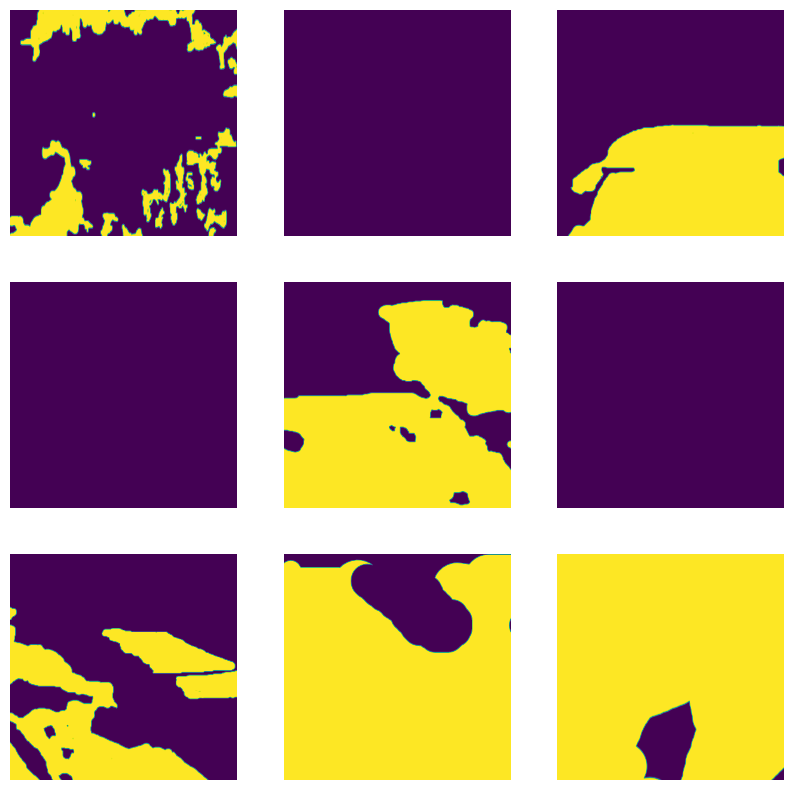

In [61]:
split_images_file = os.listdir(SPLIT_IMAGES_PATH)
range_count = 9

def checkSplitImages(index):
    split_images_file_range = split_images_file[index*range_count:(index*range_count)+range_count]

    fig_image,axis_image = plt.subplots(3,3,figsize = (10,10))
    fig_mask,axis_mask = plt.subplots(3,3,figsize = (10,10))

    print(cv2.imread(os.path.join(SPLIT_IMAGES_PATH,split_images_file_range[0])).shape)
    print(cv2.imread(os.path.join(SPLIT_MASKS_PATH,split_images_file_range[0][:-3]+'png'),cv2.IMREAD_GRAYSCALE).shape)

    for i in range(3):
        for j in range(3):
            
            split_image_cv = cv2.imread(os.path.join(SPLIT_IMAGES_PATH,split_images_file_range[(i*3)+j]))
            split_mask_cv = cv2.imread(os.path.join(SPLIT_MASKS_PATH,split_images_file_range[(i*3)+j][:-3]+'png'),cv2.IMREAD_GRAYSCALE)

            axis_image[i,j].imshow(split_image_cv)
            axis_mask[i,j].imshow(split_mask_cv)

            axis_image[i,j].axis('off')
            axis_mask[i,j].axis('off')
    

# slider = widgets.IntSlider(min = 0 ,max = (len(split_images_file)//range_count)-1)
# widgets.interactive(checkSplitImages,index = slider)
checkSplitImages(0)
            

<h1>Move image to train,validation,test</h1>

In [62]:
def moveImToTrAndValAndTest(val_test_size = 0.1):
    split_images_file = np.array(os.listdir(SPLIT_IMAGES_PATH))
    
    val_test_indices = np.random.choice(len(split_images_file) ,int(len(split_images_file)*val_test_size))
    test_indices = np.random.choice(val_test_indices ,int(len(val_test_indices)*val_test_size*2))

    mask_indices = np.zeros((len(split_images_file)))
    mask_indices[val_test_indices] = 1
    mask_indices[test_indices] = 2

    for train_image_file in split_images_file[mask_indices == 0]:
        train_image_file_path = os.path.join(SPLIT_IMAGES_PATH,train_image_file)
        train_mask_file_path = os.path.join(SPLIT_MASKS_PATH,train_image_file[:-3]+'png')

        train_image_new_path = os.path.join(TRAIN_IMAGES_PATH,train_image_file)
        train_mask_new_path = os.path.join(TRAIN_MASKS_PATH,train_image_file[:-3]+'png')

        if os.path.exists(train_image_new_path) or os.path.exists(train_mask_new_path) :
            print('Warning : %s is exists'%train_image_new_path)
            continue

        shutil.copy2(train_image_file_path,train_image_new_path)
        shutil.copy2(train_mask_file_path,train_mask_new_path)

    for val_image_file in split_images_file[mask_indices == 1]:
        val_image_file_path = os.path.join(SPLIT_IMAGES_PATH,val_image_file)
        val_mask_file_path = os.path.join(SPLIT_MASKS_PATH,val_image_file[:-3]+'png')

        val_image_new_path = os.path.join(VAL_IMAGES_PATH,val_image_file)
        val_mask_new_path = os.path.join(VAL_MASKS_PATH,val_image_file[:-3]+'png')

        if os.path.exists(val_image_new_path) or os.path.exists(val_mask_new_path) :
            print('Warning : %s is exists'%val_image_new_path)
            continue

        shutil.copy2(val_image_file_path,val_image_new_path)
        shutil.copy2(val_mask_file_path,val_mask_new_path)

    for test_image_file in split_images_file[mask_indices == 2]:
        test_image_file_path = os.path.join(SPLIT_IMAGES_PATH,test_image_file)
        test_mask_file_path = os.path.join(SPLIT_MASKS_PATH,test_image_file[:-3]+'png')

        test_image_new_path = os.path.join(TEST_IMAGES_PATH,test_image_file)
        test_mask_new_path = os.path.join(TEST_MASKS_PATH,test_image_file[:-3]+'png')

        if os.path.exists(test_image_new_path) or os.path.exists(test_mask_new_path) :
            print('Warning : %s is exists'%test_image_new_path)
            continue

        shutil.copy2(test_image_file_path,test_image_new_path)
        shutil.copy2(test_mask_file_path,test_mask_new_path)
    
    


In [63]:
# moveImToTrAndValAndTest()

<h1>Data Preparation</h1>

<h4>Make dataset from file name</h4>

In [64]:
train_images_file_path = []
train_masks_file_path = []

val_images_file_path = []
val_masks_file_path = []


for train_image_file in os.listdir(TRAIN_IMAGES_PATH):
    train_images_file_path.append(os.path.join(TRAIN_IMAGES_PATH,train_image_file))
    train_masks_file_path.append(os.path.join(TRAIN_MASKS_PATH,train_image_file[:-3]+'png'))

for val_image_file in os.listdir(VAL_IMAGES_PATH):
    val_images_file_path.append(os.path.join(VAL_IMAGES_PATH,val_image_file))
    val_masks_file_path.append(os.path.join(VAL_MASKS_PATH,val_image_file[:-3]+'png'))

<h4>Make dataset<h4>

In [65]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_file_path,train_masks_file_path))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images_file_path,val_masks_file_path))

<h4>Read image and mask file<h4>

In [66]:
def readFile(image,mask):
    image_tf = tf.image.decode_jpeg(tf.io.read_file(image),channels=3)
    mask_tf = tf.image.decode_png(tf.io.read_file(mask),channels=1)

    image_tf = tf.cast(image_tf,tf.float32)
    mask_tf = tf.cast(mask_tf,tf.float32)
    
    return image_tf,mask_tf

In [67]:
train_dataset_read = train_dataset.map(readFile)
val_dataset_read = val_dataset.map(readFile)

<h4>Data augmentation and albumenation<h4>

In [68]:
transform = A.Compose([
    A.Resize(H,W),
    A.RandomCrop(width=np.random.randint(0.9*W,W),
                 height=np.random.randint(0.9*H,H),
                 p=0.5),
    A.RandomScale(scale_limit=0.1,interpolation=cv2.INTER_LANCZOS4,p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Resize(H,W)
])

In [69]:
def albumentAugment(image,mask):
    trans_output = transform(image = image ,mask = mask)
    image = trans_output['image']
    mask = trans_output['mask']

    return image,mask

In [70]:
def process_data(image,mask):
    album_aug = tf.numpy_function(albumentAugment ,inp=(image,mask) ,Tout=(tf.float32,tf.float32))
    return album_aug[0] ,album_aug[1]

In [71]:
train_dataset_aug = train_dataset_read.map(process_data)

In [72]:
def preprocessAugment(image,mask):
    THRESH = 0.5
    image = tf.image.random_brightness(image ,max_delta=50.)
    image = tf.image.random_saturation(image ,lower=0.5 ,upper=1.5)
    image = tf.image.random_contrast(image,lower=0.5,upper=1.5)
    image = tf.clip_by_value(image,0,255)
    mask = tf.clip_by_value(mask,0,255)
    mask = mask/255.
    mask = tf.where(mask >= THRESH ,1. ,0.)
    
    return image,mask

In [73]:
train_dataset_preprocessed = train_dataset_aug.map(preprocessAugment)

In [74]:
def preprocess(image ,mask):
    THRESH = 0.5
    image = tf.image.resize(image ,(H,W))
    mask = tf.image.resize(mask ,(H,W) ,method='nearest')
    mask = tf.clip_by_value(mask,0,255)
    mask = mask/255.
    mask = tf.where(mask >= THRESH ,1. ,0.)

    return image,mask

In [75]:
val_dataset_preprocessed =  val_dataset_read.map(preprocess)

<h2>Check dataset after preprocessing</h2>

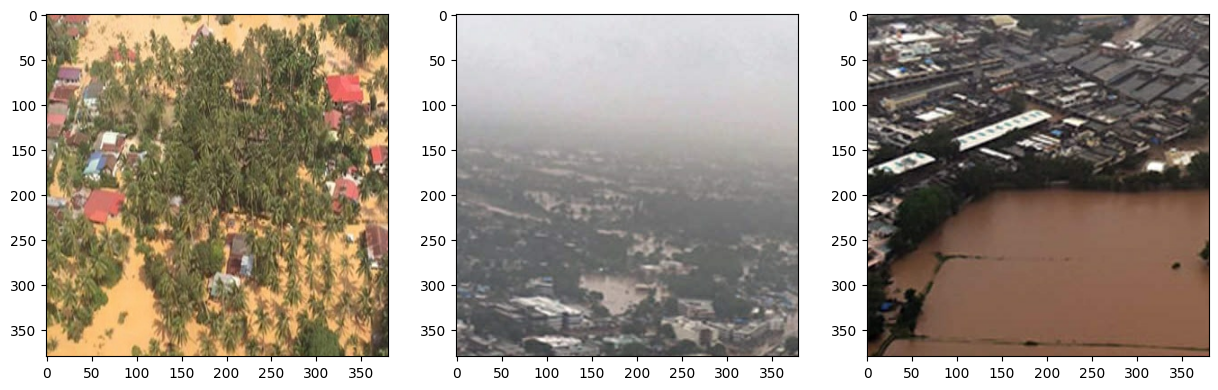

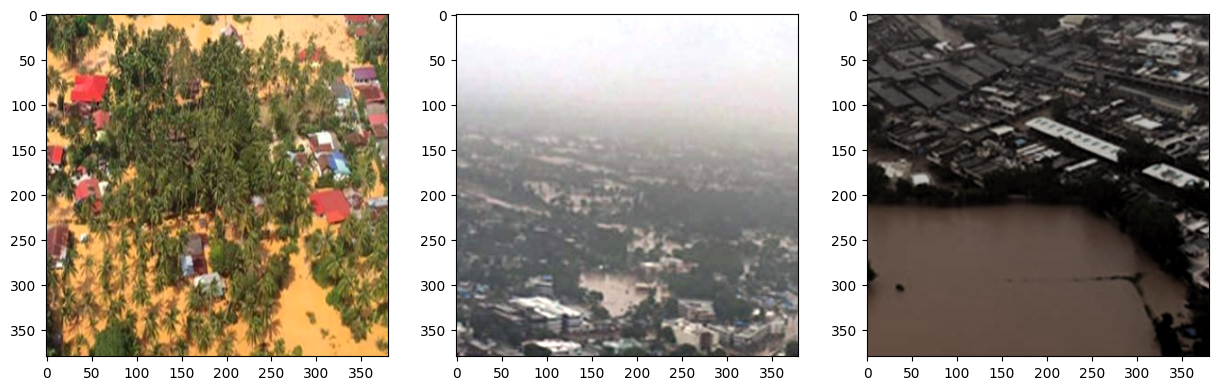

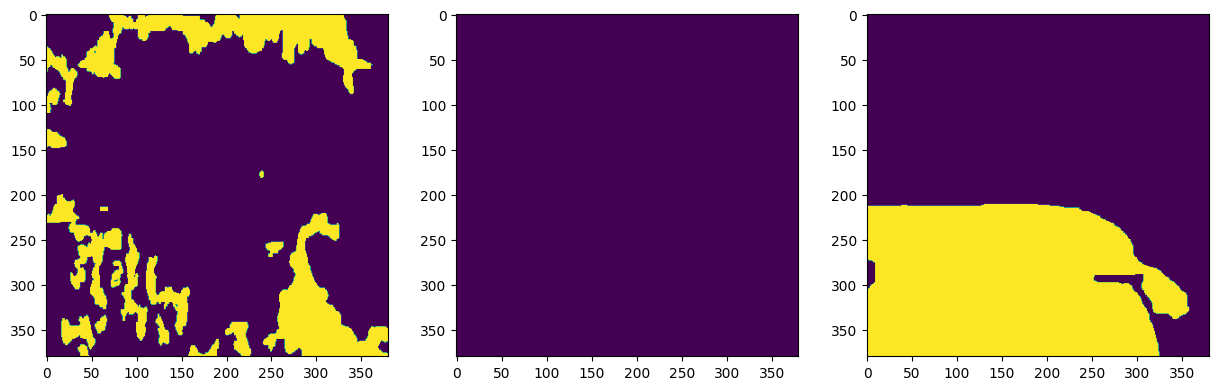

In [76]:
fig,axis_image = plt.subplots(1,3,figsize = (15,15))
fig,axis_image_aug = plt.subplots(1,3,figsize = (15,15))
fig,axis_mask_aug  = plt.subplots(1,3,figsize = (15,15))

count_show = 0
for index,((image_aug,mask_aug),(image,mask)) in enumerate(zip(train_dataset_preprocessed,train_dataset_read)):
    if count_show == 3:
        break

    count_show += 1
    # axis_image[index//3,index-((index//3)*3)].imshow(image.numpy()/255.)
    # axis_image_aug[index//3,index-((index//3)*3)].imshow(image_aug.numpy()/255.)
    # axis_mask_aug[index//3,index-((index//3)*3)].imshow(mask_aug.numpy())

    axis_image[index].imshow(image.numpy()/255.)
    axis_image_aug[index].imshow(image_aug.numpy()/255.)
    axis_mask_aug[index].imshow(mask_aug.numpy())


In [77]:
train_dataset_processed = train_dataset_preprocessed.batch(BATCH_SIZE ,drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_dataset_processed = val_dataset_preprocessed.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [78]:
for x,y in train_dataset_processed:
    print(x.shape)
    print(y.shape)
    print(np.unique(y.numpy()[0]))
    break

(32, 380, 380, 3)
(32, 380, 380, 1)
[0. 1.]


<h1>Model</h1>

In [79]:
back_bone = tf.keras.applications.EfficientNetB4(include_top=False,weights='imagenet',input_shape=(H,W,3))
back_bone.trainable = False

In [80]:
skip_connections = [
    back_bone.get_layer('block2a_expand_activation').output,
    back_bone.get_layer('block3a_expand_activation').output,
    back_bone.get_layer('block4a_expand_activation').output,
    back_bone.get_layer('block6a_expand_activation').output
]
x = back_bone.get_layer('top_activation').output

def decode_block(x ,skip_connection ,filters):
    x = tf.keras.layers.UpSampling2D((2,2) ,interpolation="bilinear")(x)
    if skip_connection == None:
        if not x.shape[1] == 380 : 
            x = tf.keras.layers.ZeroPadding2D(((0, 1), (0, 1)))(x)    
    else:
        if not x.shape[1] == skip_connection.shape[1]:
            x = tf.keras.layers.Cropping2D(((0, 1), (0, 1)))(x)
        x = tf.keras.layers.Concatenate(axis=-1)([x ,skip_connection])
        

    x = tf.keras.layers.Conv2D(filters ,kernel_size=(3,3) ,padding='same' ,activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters ,kernel_size=(3,3) ,padding='same' ,activation='relu')(x)

    return x

x = decode_block(x ,skip_connections[3] ,512)
x = decode_block(x ,skip_connections[2] ,256)
x = decode_block(x ,skip_connections[1] ,128)
x = decode_block(x ,skip_connections[0] ,64)
x = decode_block(x ,None ,32)

output = tf.keras.layers.Conv2D(1 ,kernel_size=(1,1) ,activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=back_bone.input ,outputs=output)
 
           

In [81]:
random_image = tf.random.uniform((1,380,380,3),minval=0. ,maxval=255.)
model(random_image).shape

TensorShape([1, 380, 380, 1])

<h3>Loss function</h3>

In [82]:
def dice_loss_func(y_true ,y_hat ,smooth=1e-6):
    intersection = tf.reduce_sum(y_true*y_hat ,axis=[1, 2, 3])
    total_sum = tf.reduce_sum(y_true ,axis=[1, 2, 3]) + tf.reduce_sum(y_hat ,axis=[1, 2, 3])

    dice_coefficient = (intersection*2.+smooth) / total_sum+smooth
    loss = 1-tf.reduce_mean(dice_coefficient)

    return loss

<h3>Callbacks</h3>

In [83]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=WEIGHTS_FILE_PATH,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min'
)

In [84]:
def scheduler(epoch,lr):
    if epoch < 10:
        return 1e-4
    if epoch >=10 and epoch<20:
        return 5e-5
    else:
        return 1e-5

In [85]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [86]:
csvlogger = tf.keras.callbacks.CSVLogger(CSV_FILE_PATH ,append=True)

In [87]:
model.compile(
    loss=dice_loss_func,
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    )

In [88]:
model.load_weights(WEIGHTS_FILE_PATH)

In [89]:
# model.fit(
#     train_dataset_processed,
#     validation_data=val_dataset_processed,
#     epochs=N_EPOCHS,
#     verbose=1,
#     callbacks=[callback,lr_callback,csvlogger]
# )

<h1>Test<h1>

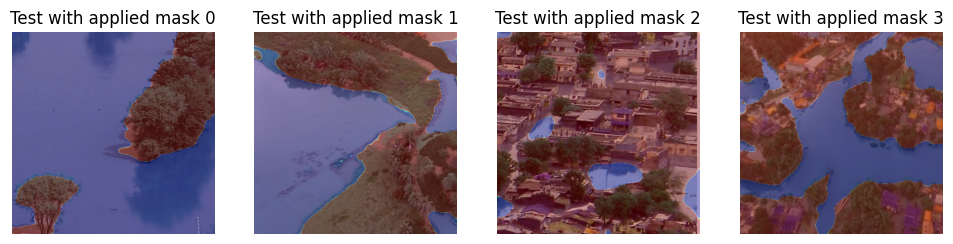

In [90]:
test_images_file = os.listdir(TEST_IMAGES_PATH)
def testImage(index):
    fig, axis = plt.subplots(1,4,figsize =(15,9))
    for index_image in range(index*4,(index*4)+4):
        test_image_file_path = os.path.join(TEST_IMAGES_PATH,test_images_file[index_image])
    
        test_image_cv2 = cv2.imread(test_image_file_path, cv2.IMREAD_COLOR)
        test_image_tensor = tf.image.decode_jpeg(tf.io.read_file(test_image_file_path), channels=3)

        output_mask = model(tf.expand_dims(test_image_tensor,axis=0)).numpy()[0]
        output_mask = (output_mask*255).astype(np.uint8)

        output_colormap = cv2.applyColorMap(output_mask, cv2.COLORMAP_JET)
        blended_image = cv2.addWeighted(test_image_cv2 ,0.6 ,output_colormap, 0.4, 0)

        axis[index_image].imshow(blended_image)
        axis[index_image].set_title('Test with applied mask %s'%index_image)
        axis[index_image].axis('off')

# slider_testImage = widgets.IntSlider(min = 0, max = len(test_images_file)/4)
# widgets.interactive(testImage, index = slider_testImage)
testImage(0)

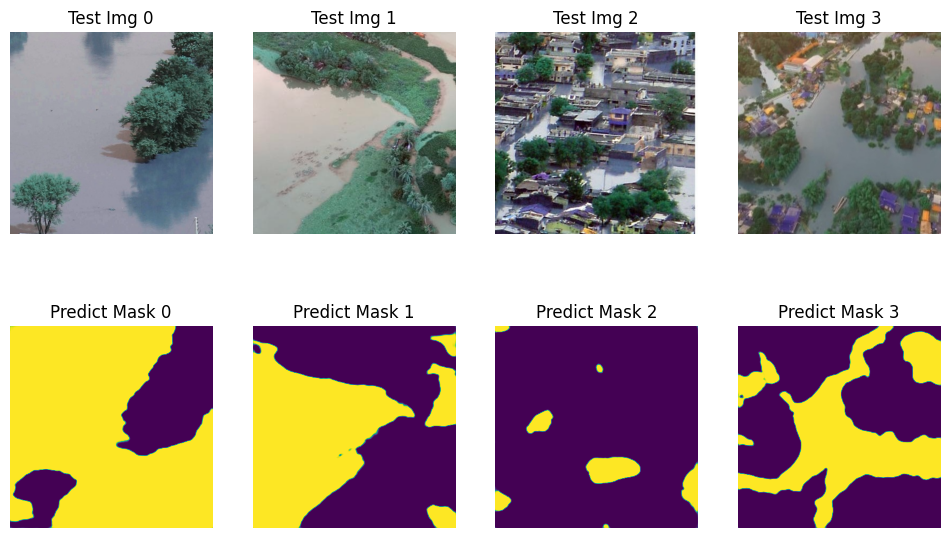

In [91]:
def testImage2(index):
    fig, axis = plt.subplots(2,4,figsize =(12,7))
    for index_image in range(index*4,(index*4)+4):
        test_image_file_path = os.path.join(TEST_IMAGES_PATH,test_images_file[index_image])
    
        test_image_cv2 = cv2.imread(test_image_file_path, cv2.IMREAD_COLOR)
        test_image_tensor = tf.image.decode_jpeg(tf.io.read_file(test_image_file_path), channels=3)

        output_mask = model(tf.expand_dims(test_image_tensor,axis=0)).numpy()[0]

        axis[0,index_image].imshow(test_image_cv2)
        axis[0,index_image].set_title('Test Img %s'%index_image)
        axis[0,index_image].axis('off')

        axis[1,index_image].imshow(output_mask)
        axis[1,index_image].set_title('Predict Mask %s'%index_image)
        axis[1,index_image].axis('off')




# slider_testImage2 = widgets.IntSlider(min = 0, max = len(test_images_file)//4)
# widgets.interactive(testImage2, index = slider_testImage2)
testImage2(0)